## Case-Study: Maintenance Communities within the RNV network


The RNV (Rhein-Neckar-Verkehr GmbH) wants to improve its ability to respond to break-downs in their transportation network by reorganizing their service and maintenance organization. The current plan is to replace the single maintenance team for the entire network with three maintenance teams, each responsible for a small set of stops in the RNV network.

Your objective is to propose three sets of stops to the RNV that will enable them to create the three maintenance teams they plan to implement. Each set of stops should be assigned to a different maintenance team to ensure that the RNV network can be properly maintained and serviced.

![rnv_graph.png](https://drive.google.com/uc?id=1lQnbnIscBtmVw5R-vrX2ijaxa9xWUxCh)

The RNV network contains tram stops and their connections in the network. Each stop is represented by a node, and the connections between them are represented by edges.
The network was created based on the data from the [RNV open data portal](https://www.opendata-oepnv.de//ht/de/organisation/verkehrsunternehmen/rnv/openrnv/datensaetze?tx_vrrkit_view%5Bdataset_name%5D=soll-fahrplandaten-rnv&tx_vrrkit_view%5Baction%5D=details&tx_vrrkit_view%5Bcontroller%5D=View).


Build a network graph using the tram stop dataset, where each stop is a node, and each connection between stops is an edge.
Visualize the graph.

In [1]:
import networkx as nx
# Load the graph and exclude the weights.
G_rnv = nx.read_edgelist("./rnv_connected_stations.txt", create_using=nx.Graph(), delimiter='\t', data=False)
print('Number of stops (nodes): ', len(G_rnv.nodes))
print('Number of connections (edges): ', len(G_rnv.edges))

Number of stops (nodes):  460
Number of connections (edges):  555


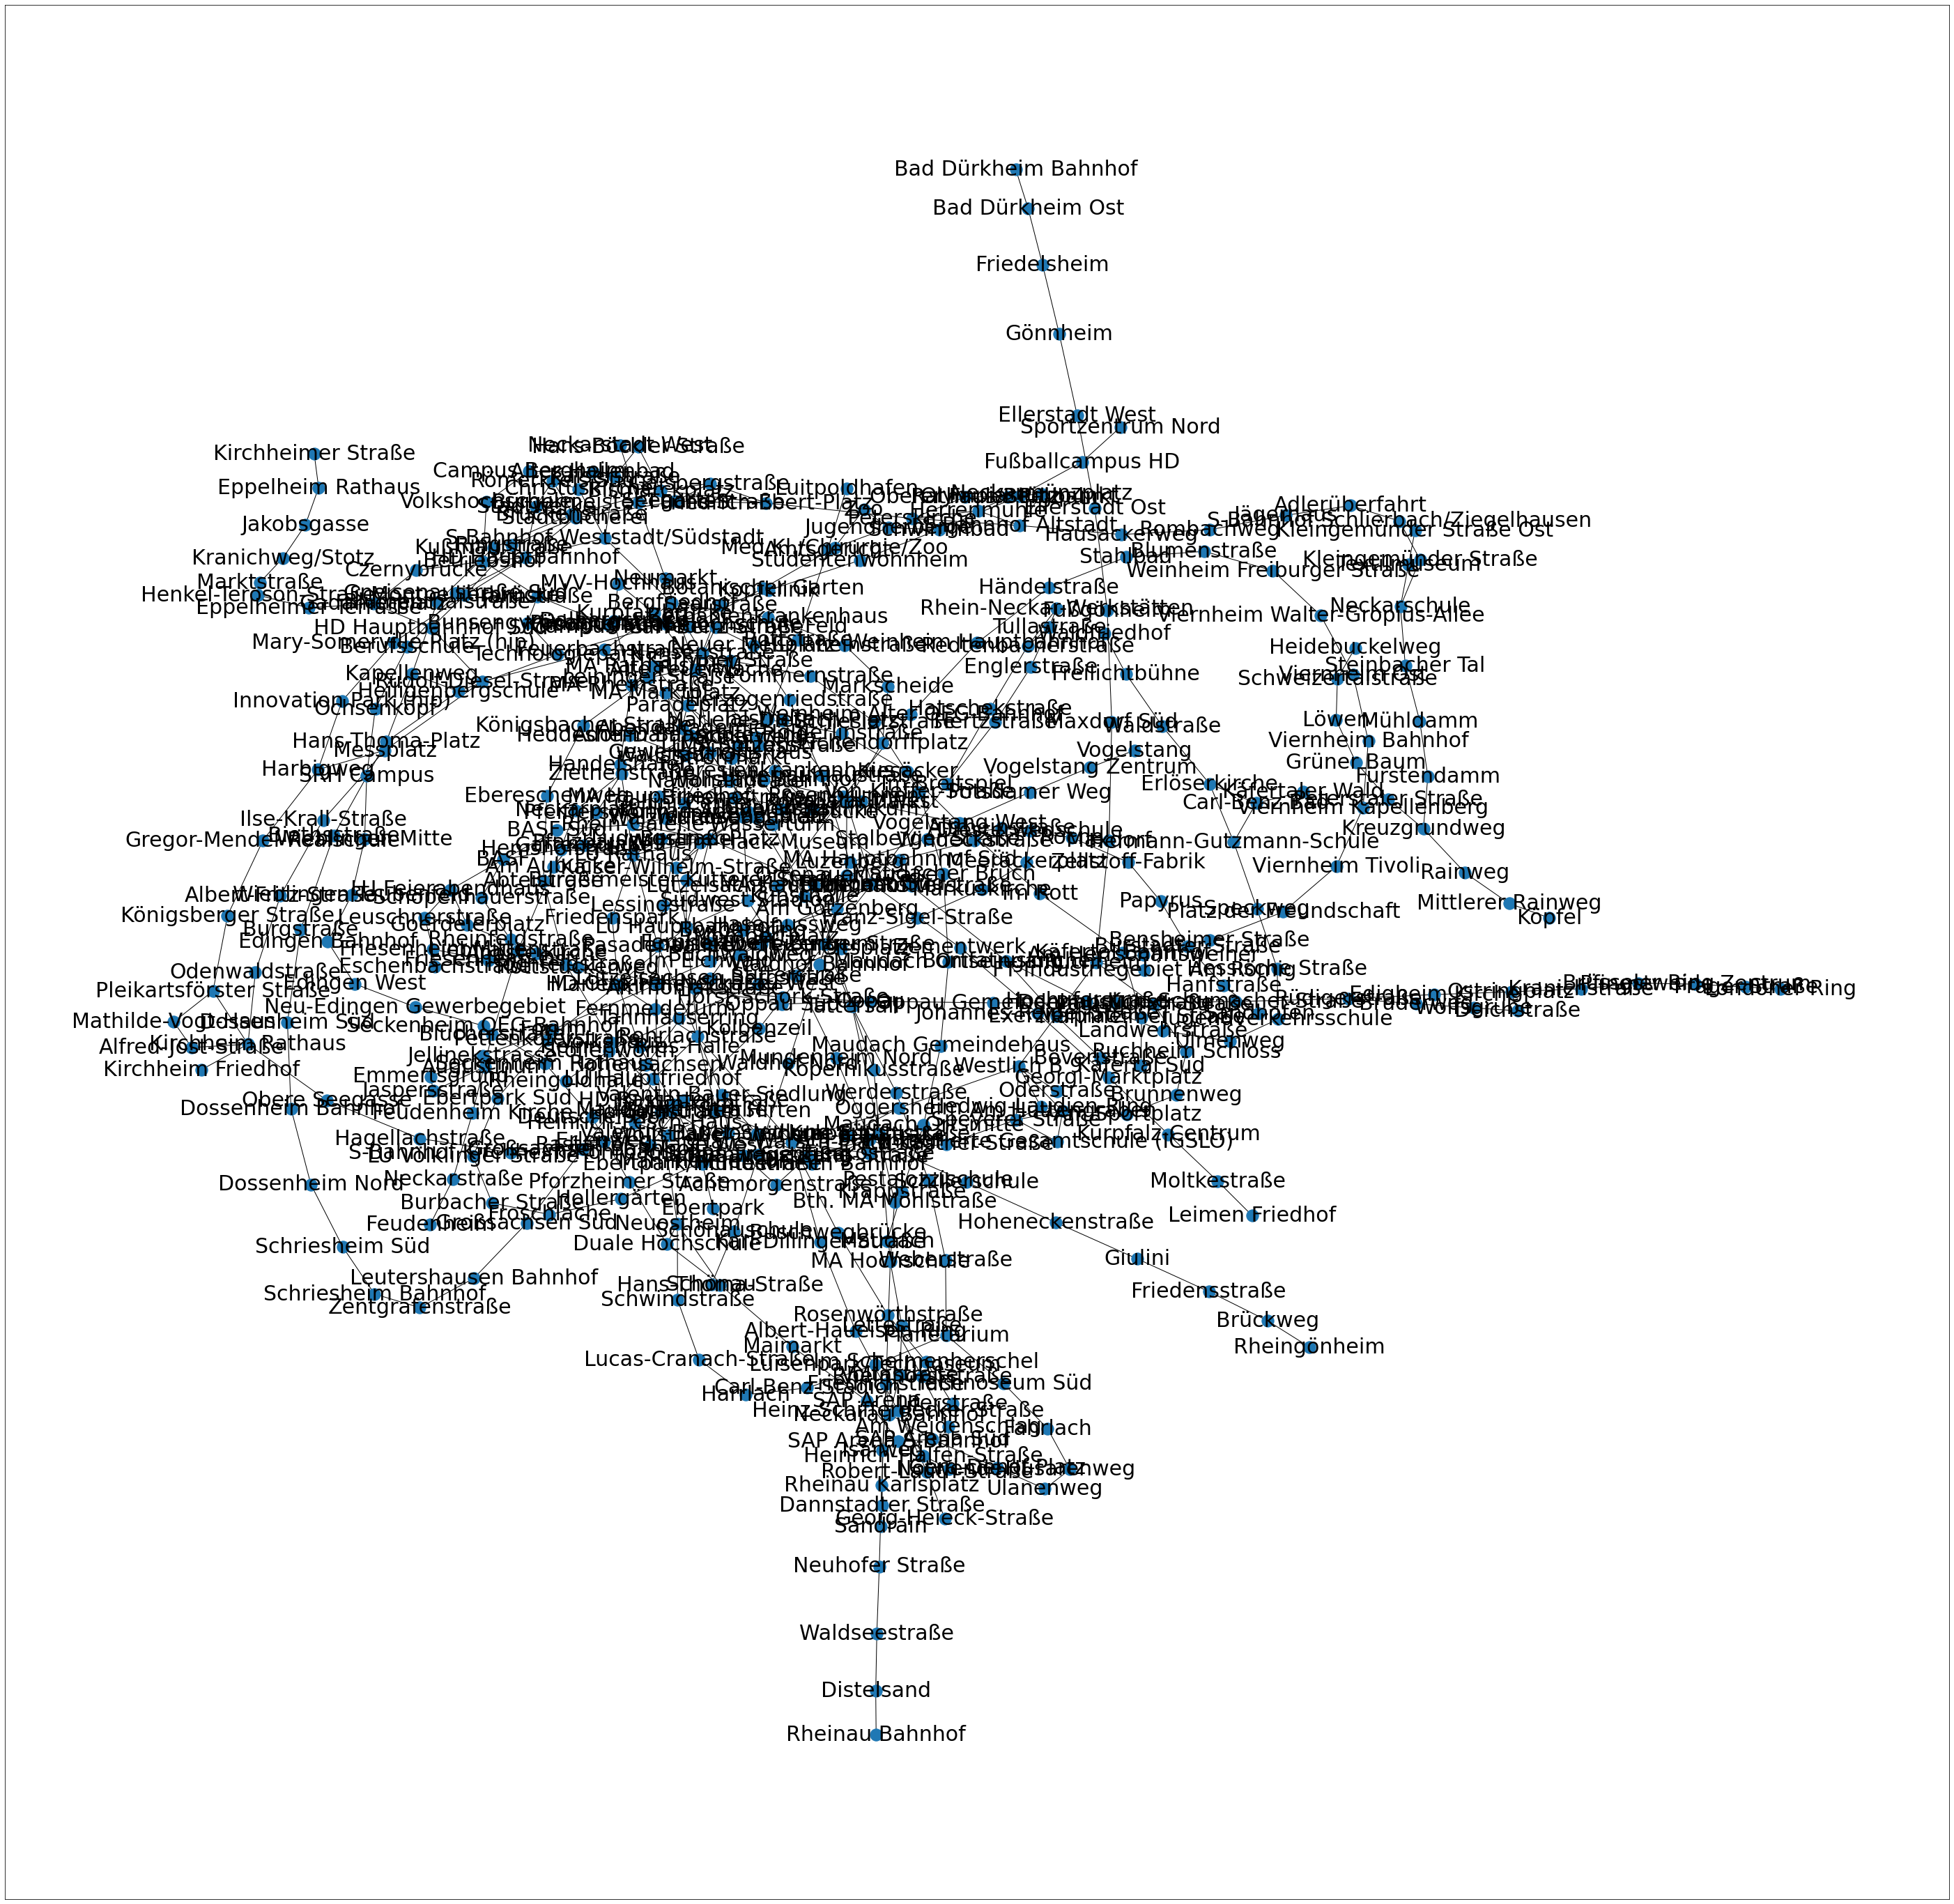

In [2]:
import matplotlib.pyplot as plt

nx.draw_networkx(G_rnv, font_size=30)
fig = plt.gcf()
fig.set_size_inches(50, 50)
plt.show()

## K-Cores

Run the k-cores algorithm to detect communities in the network.
Each stop should be at least connected to 3 other stops.

Visulize the resulting graph and interpret the result.
- Are k-cores a suitable approach for splitting the RNV network into groups of stations that are to be maintained by the different maintenance teams? 
- If not, which methods could deliver better results?

Component:
	 Friedrich-Ebert-Platz
	 Bismarckplatz
	 Seegarten
	 Gaisbergstraße

Component:
	 Westlich B 9
	 Speyerer Straße
	 Am Hüttengraben
	 Hedwig-Laudien-Ring



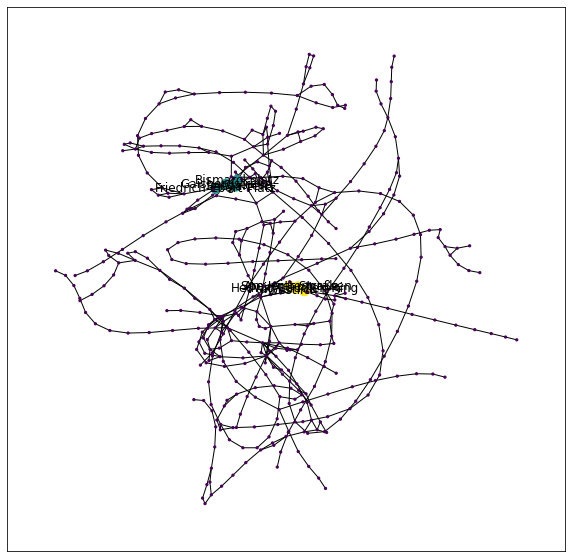

In [3]:
# Use Networkx k_core method with k=3
G_rnv_3_core = nx.k_core(G_rnv, 3)

# Initialize label, color and size dict for visualizing the graphs
node_label_dict = {v: '' for v in G_rnv.nodes()}
node_color_dict = {v:5 for v in G_rnv.nodes()}
node_size_dict = {v:5 for v in G_rnv.nodes()}

pos = nx.spring_layout(G_rnv, scale=5, seed=42)
current_color = 0
for component in nx.connected_components(G_rnv_3_core):
    # Change color of nodes with this component
    current_color += 100
    print('Component:')
    for node in component:
        # Add node color and size
        node_color_dict[node] = current_color
        
        print('\t {}'.format(node))
        # Add node label and size for the visualization
        node_label_dict[node] = node
        node_size_dict[node] = 100
    print('')
# Set node size and color of the output network
node_size = [node_size_dict[v] for v in G_rnv.nodes()]
node_color = [node_color_dict[v] for v in G_rnv.nodes()]

# Draw the network
plt.figure(figsize=(10,10))
nx.draw_networkx(G_rnv, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size, labels=node_label_dict )
plt.show()

K-cores are a type of subgraph in a network where all nodes have at least k connections to other nodes within the subgraph. In the context of the RNV's transportation network, k-cores can be used to identify sets of stops that are highly interconnected. 

Unfortunately, the most stops of the RNV graph are not highly connected, because usually one stop is connected to at most two other stations. k-cores is not helpful in this context. Additionally, we neglect many stops in the network, because they are not added to any component.

## Divisive Hierarchical Clustering

Use divisive clustering to detect communities in the network.
The measure to find strong edges is edge betweenness.

Keep in mind that your goal is to identity 3 maintenance organizations (communitites).

In [4]:
# Divisive Clustering based on Edge Betweenness
G_rnv_clustered = G_rnv.copy()

while(True):
    # Identify "weakest" edge
    top_betweeness_edge_score = sorted(nx.edge_betweenness_centrality(G_rnv_clustered).items(), key=lambda item: item[1], reverse=True)[0]
    top_betweeness_edge = top_betweeness_edge_score[0]
    
    # Remove edge
    G_rnv_clustered.remove_edge(top_betweeness_edge[0], top_betweeness_edge[1])
    
    # Stop removing edges as soon as the graph is split into three components.
    if nx.number_connected_components(G_rnv_clustered) == 3:
        break

print('Number of components: {}'.format(nx.number_connected_components(G_rnv_clustered)))

Number of components: 3


Please visualize the maintenance groups in the graph. 

Each maintenance group needs a depot within their sub-component of the graph.
Determine for each maintenance group the five stops with the highest importance for the reliability of the network in the respective sub-component. A depot can be placed at one of these stops.

Which measure is suitable to determine the importance of a station for the reliability of the network?

Stops with the highest betweeness scores of the component: 
	 Rosengarten
	 Wasserturm
	 Alte Feuerwache
	 Kunsthalle
	 Universitätsklinikum
Stops with the highest betweeness scores of the component: 
	 Westlich B 9
	 Rohrlachstraße
	 Valentin-Bauer-Siedlung
	 LU Hochschule
	 Hans-Warsch-Platz
Stops with the highest betweeness scores of the component: 
	 S-Bahnhof Weststadt/Südstadt
	 Jahnstraße
	 Nansenstraße
	 Betriebshof
	 HD Hauptbahnhof


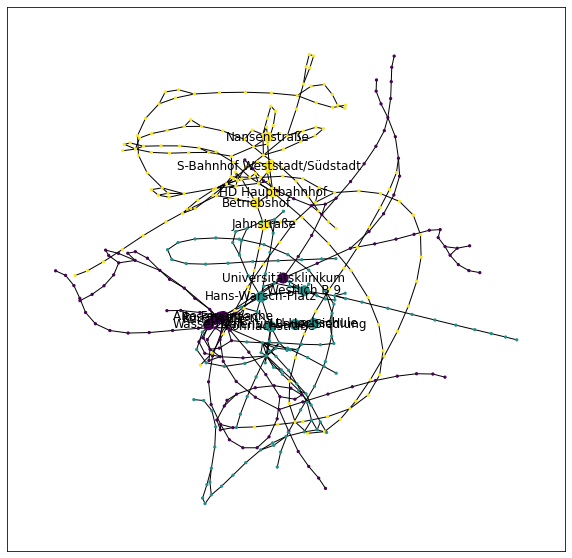

In [5]:
# Initialize label, color and size dict for visualizing the graphs
node_label_dict = {v: '' for v in G_rnv.nodes()}
node_color_dict = {v:5 for v in G_rnv.nodes()}
node_size_dict = {v:5 for v in G_rnv.nodes()}

pos = nx.spring_layout(G_rnv, scale=5, seed=42)
current_color = 0
for component in nx.connected_components(G_rnv_clustered):
    # Change color of nodes with this component
    current_color += 100
    print('Stops with the highest betweeness scores of the component: ')
    # Determine subgraph of component and determine stops with the highest betweeness scores
    component_graph = G_rnv_clustered.copy()
    component_graph.remove_nodes_from([n for n in component_graph if n not in set(component)])
    top_betweeness_score_stops = [k for k,v in 
                                  sorted(nx.betweenness_centrality(component_graph, normalized =True).items(), 
                                         key=lambda item: item[1], reverse=True)[:5]]

    for node in component:
        # Add node color and size
        node_color_dict[node] = current_color

        if node in top_betweeness_score_stops:
            print('\t {}'.format(node))
            # Add node label and size for the visualization
            node_label_dict[node] = node
            node_size_dict[node] = 100

# Set node size and color of the output network
node_size = [node_size_dict[v] for v in G_rnv.nodes()]
node_color = [node_color_dict[v] for v in G_rnv.nodes()]

# Draw the network
plt.figure(figsize=(10,10))
nx.draw_networkx(G_rnv, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size, labels=node_label_dict )
plt.show()

We were looking for the betweenness score of the stops within the subcomponent.

The result of the divisive clustering technique is great, because it has successfully divided the network into three distinct components. What makes this finding even more fascinating is that each component represents one of the three cities Mannheim, Ludwigshafen, and Heidelberg. The division of the network into these communities is intuitively reasonable and could be highly valuable in helping the RNV reorganize their service and maintenance organization.

## Assignment : Game of Thrones: Network Analysis and community detection 

Your objective is to analyze the Game of Thrones network using the Networkx library, you will find below Datasets of the different books: 

https://github.com/mathbeveridge/asoiaf/tree/master/data 

here some basic tutorials that you can start with: 

https://www.kaggle.com/mmmarchetti/game-of-thrones-network-analysis

https://dzone.com/articles/analyzing-relationships-in-game-of-thrones-with-ne-1

You have the choice to use whatever algorithms you want. However, you must answer a set of questions:

1. What is the most important caracter ?
2. Try multiple centrality measures, how can you interprete the output giving your domain knowledge (I presume that you already watched this serie :))
2. The evolution of Tyrion over the seasons (books)
3. Try multiple community detection algorithms, which one reflect the real communities (houses) in the serie and why ? 
4. ... 4 questions of your choice with a suitable answer 

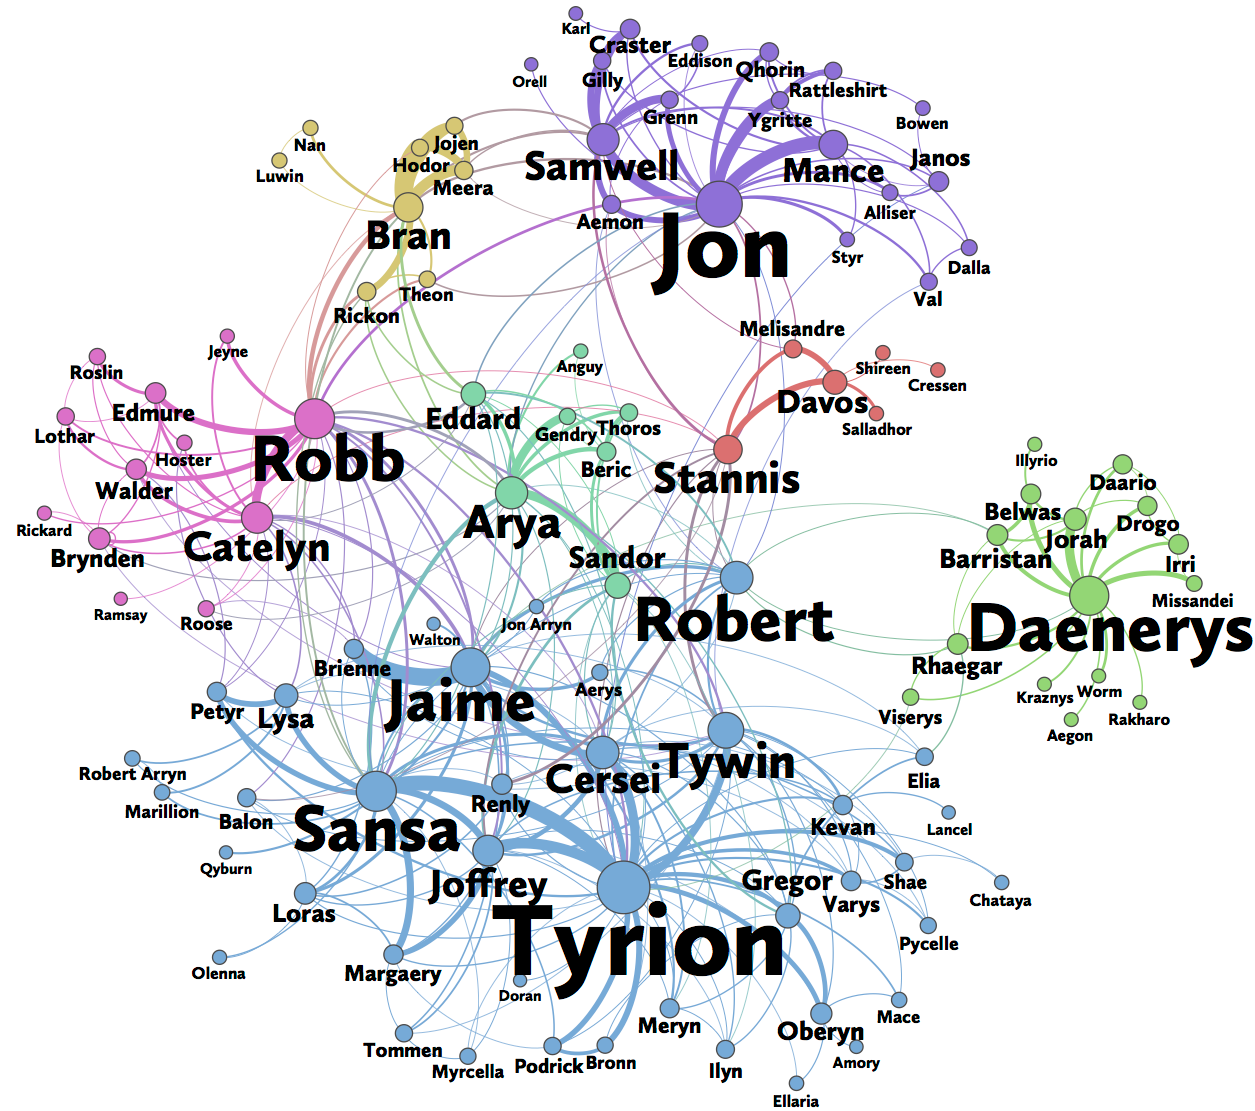

## 1 - What is the most important character ?

       From the Graph, Tyrion-Lannister is the most important character since it has the biggest node

## 2 - Try multiple centrality measures, how can you interprete the output giving your domain knowledge ?

In [104]:
import pandas as pd

url = 'https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-all-edges.csv'
all_book = pd.read_csv(url)
print(all_book.head(5))

           Source            Target        Type  id  weight
0  Addam-Marbrand     Brynden-Tully  Undirected   0       3
1  Addam-Marbrand  Cersei-Lannister  Undirected   1       3
2  Addam-Marbrand       Gyles-Rosby  Undirected   2       3
3  Addam-Marbrand   Jaime-Lannister  Undirected   3      14
4  Addam-Marbrand      Jalabhar-Xho  Undirected   4       3


In [55]:
import networkx as nx
# Creating an empty graph object
G_all = nx.Graph()
G_all

In [56]:
# Iterating through the DataFrame to add edges
for _,edge in all_book.iterrows():
    G_all.add_edge(edge['Source'], edge['Target'], weight=edge['weight'])
G_all

In [57]:
# Calculating the degree centrality
deg_cen_all = nx.degree_centrality(G_all)
sorted_deg_cen_all =  sorted(deg_cen_all.items(), key=lambda x:x[1], reverse=True)[0:10]
sorted_deg_cen_all

[('Tyrion-Lannister', 0.15345911949685534),
 ('Jon-Snow', 0.14339622641509434),
 ('Jaime-Lannister', 0.1270440251572327),
 ('Cersei-Lannister', 0.1220125786163522),
 ('Stannis-Baratheon', 0.11194968553459118),
 ('Arya-Stark', 0.10566037735849056),
 ('Catelyn-Stark', 0.09433962264150943),
 ('Sansa-Stark', 0.09433962264150943),
 ('Robb-Stark', 0.0930817610062893),
 ('Eddard-Stark', 0.0930817610062893)]

    Highest degree centrality : Tyrion-Lannister

**Degree centrality**: Tyrion Lannister's high degree centrality in the network is due to his interactions with many characters throughout the "Game of Thrones" story. He travels to different regions, joins different houses, and knows a large number of characters, which all contribute to his high degree centrality.

In [80]:
# Calculating the betweeness centrality
bet_cen_all = nx.betweenness_centrality(G_all)
sorted_bet_cen_all =  sorted(bet_cen_all.items(), key=lambda x:x[1], reverse=True)[0:10]
sorted_bet_cen_all

[('Jon-Snow', 0.1921196196835449),
 ('Tyrion-Lannister', 0.1621910961115984),
 ('Daenerys-Targaryen', 0.11841801916269204),
 ('Theon-Greyjoy', 0.11128331813470228),
 ('Stannis-Baratheon', 0.11013955266679566),
 ('Jaime-Lannister', 0.10083800602581632),
 ('Cersei-Lannister', 0.08870426655860289),
 ('Arya-Stark', 0.08724236063571153),
 ('Eddard-Stark', 0.07873239257251873),
 ('Robert-Baratheon', 0.07822769060383258)]

    Highest betweeness centrality : Jon Snow

**Betweenness centrality**: Jon Snow's position as the top node based on betweenness centrality is due to his connections to characters from different regions and factions, as well as his diplomatic skills in negotiating alliances and maintaining peace. He acts as a gatekeeper in the network, connecting different characters and groups who might not otherwise be connected to each other.

In [236]:
# Calculating the pagerank centrality
ev_cen_all = nx.pagerank(G_all)
sorted_ev_cen_all =  sorted(ev_cen_all.items(), key=lambda x:x[1], reverse=True)[0:10]
sorted_ev_cen_all

[('Jon-Snow', 0.0356937645004584),
 ('Tyrion-Lannister', 0.03284906001585236),
 ('Cersei-Lannister', 0.023607038592018494),
 ('Daenerys-Targaryen', 0.02230688198724802),
 ('Jaime-Lannister', 0.019753549619362144),
 ('Eddard-Stark', 0.018938219584721857),
 ('Arya-Stark', 0.018538944931775433),
 ('Stannis-Baratheon', 0.01805167123106783),
 ('Joffrey-Baratheon', 0.01742008392061762),
 ('Robb-Stark', 0.017344651104667343)]

    Highest pagerank centrality : Tyrion-Lannister

**PageRank centrality**: Jon Snow's high Pagerank centrality is due to his connections to many important characters in the network, as well as his central role in the story and significant impact on the plot. He is married to the queen of dragons, discovers he is the legitimate heir of the throne, and his actions have a significant impact on major battles, all contributing to his importance as a node in the network.

In [79]:
# Calculating the closeness centrality
cn_cen_all = nx.closeness_centrality(G_all)
sorted_cn_cen_all =  sorted(cn_cen_all.items(), key=lambda x:x[1], reverse=True)[0:10]
sorted_cn_cen_all

[('Tyrion-Lannister', 0.4763331336129419),
 ('Robert-Baratheon', 0.4592720970537262),
 ('Eddard-Stark', 0.455848623853211),
 ('Cersei-Lannister', 0.45454545454545453),
 ('Jaime-Lannister', 0.4519613416714042),
 ('Jon-Snow', 0.44537815126050423),
 ('Stannis-Baratheon', 0.4446308724832215),
 ('Robb-Stark', 0.4441340782122905),
 ('Joffrey-Baratheon', 0.4339519650655022),
 ('Catelyn-Stark', 0.4334787350054526)]

    Highest closeness centrality : Tyrion-Lannister

**Closeness centrality**: Tyrion Lannister's high closeness centrality is due to his interactions with a wide range of characters from different factions and houses, as well as his knowledge of many different regions. He is able to connect with characters from different parts of the network due to his travels and experiences.


## 3 - The evolution of Tyrion over the seasons (books)

In [218]:
# Creating a list of networks for all the books
books = []
book_fnames = ['https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book1-edges.csv',
               'https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book2-edges.csv',
               'https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book3-edges.csv',
               'https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book4-edges.csv',
               'https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book5-edges.csv']
for book_fname in book_fnames:
    book = pd.read_csv(book_fname)
    G_book = nx.Graph()
    for _, edge in book.iterrows():
        G_book.add_edge(edge['Source'], edge['Target'], weight=edge['weight'])
    books.append(G_book)

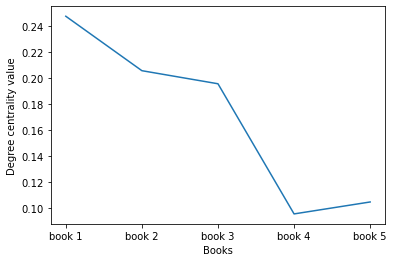

In [219]:
%matplotlib inline

# Creating a list of degree centrality of all the books
evol = [nx.degree_centrality(book) for book in books]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

# Plotting the degree centrality evolution of Tyrion-Lannister
plt.plot(['book 1','book 2','book 3','book 4','book 5'],degree_evol_df['Tyrion-Lannister'])
plt.xlabel("Books")
plt.ylabel("Degree centrality value")
plt.show()

In [220]:
book1 = pd.read_csv(book_fnames[0])
book2 = pd.read_csv(book_fnames[1]) 
book3 = pd.read_csv(book_fnames[2])
book4 = pd.read_csv(book_fnames[3])
book5 = pd.read_csv(book_fnames[4])

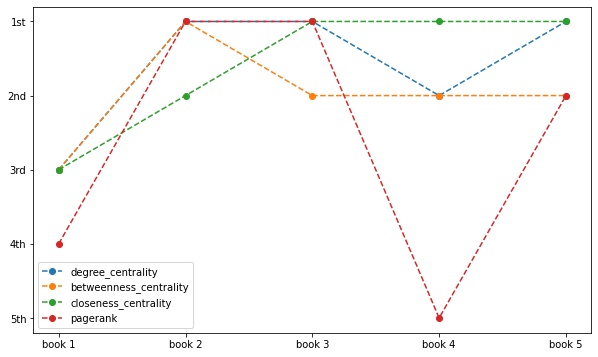

In [235]:
def G_edges(books,fct):
    ranks=[]
    G = nx.Graph()
    for book in books:
        lst = []
        temp=[]
        for _,edge in book.iterrows():
            G.add_edge(edge['Source'], edge['Target'], weight=edge['weight'])
        srtd = sorted(fct(G).items(), key=lambda x:x[1], reverse=True)[0:10] 
        lst = [temp[0] for temp in srtd]
        ranks.append(-lst.index('Tyrion-Lannister'))
    
    return ranks
books = [book1,book2,book3,book4,book5]
lst1 = G_edges(books,nx.degree_centrality)
lst2 = G_edges(books,nx.betweenness_centrality)
lst3 = G_edges(books,nx.closeness_centrality)
lst4 = G_edges(books,nx.pagerank)

plt.figure(figsize=(10,6))

for i in [lst1,lst2,lst3,lst4]:
    plt.plot(['book 1','book 2','book 3','book 4','book 5'],i,'o')
    
plt.legend(['degree_centrality','betweenness_centrality','closeness_centrality','pagerank'])
plt.yticks([0, -1, -2,-3,-4], ['1st', '2nd', '3rd','4th','5th'])
plt.show()

    In "A Clash of Kings," the second book in the "A Song of Ice and Fire" series, Tyrion's appointment as Hand of the King led to an increase in his degree centrality and pagerank centrality in the network as he gained more power and influence. He interacted with more characters and became a mediator between different factions.

    However, in "A Storm of Swords," the third book in the series, Tyrion's situation changed dramatically when he was accused of the murder of King Joffrey Baratheon at the Purple Wedding, a crime he did not commit. Many characters turned against him, causing his degree centrality to decrease as he interacted with fewer characters while in hiding. Additionally, his betweenness centrality decreased as he lost his mediator role and became isolated from the network.

## 4 - Try multiple community detection algorithms, which one reflect the real communities (houses) in the serie and why ?

In [237]:
from networkx.algorithms import community
# Detect communities using the Louvain algorithm
partition = community.greedy_modularity_communities(G_all)

# Print the communities
for i, comm in enumerate(partition):
    print(f"Community {i+1}: {comm}")


Community 1: frozenset({'Aemon-Targaryen-(Dragonknight)', 'Torrhen-Karstark', 'Willis-Wode', 'Cleos-Frey', 'Leaf', 'Wyman-Manderly', 'Hosteen-Frey', 'Petyr-Frey', 'Rhaegar-Frey', 'Moreo-Tumitis', 'Jason-Mallister', 'Petyr-Baelish', 'Lothar-Frey', 'Damon-Dance-for-Me', 'Lyonel-Corbray', 'Osha', 'Dacey-Mormont', 'Stiv', 'Kyra', 'Maege-Mormont', 'Marq-Piper', 'Gawen-Westerling', 'Dagmer', 'Heward', 'Cayn', 'Shitmouth', 'Rennifer-Longwaters', 'Captain-Myraham', 'Poxy-Tym', 'Wyl-(guard)', 'Walda-Frey-(daughter-of-Merrett)', 'Harl', 'Benedar-Belmore', 'Sour-Alyn', 'Theon-Greyjoy', 'Nage', 'Harwin', 'Shadd', 'Martyn-Rivers', 'Nan', 'Tristifer-IV-Mudd', 'Varly', 'Anya-Waynwood', 'Alyn', 'Symond-Templeton', 'Rollam-Westerling', 'Olyvar-Frey', 'Bran-Stark', 'Cley-Cerwyn', 'Roslin-Frey', 'Aenys-Frey', 'Captain-Myraham-Daughter', 'Stygg', 'Halys-Hornwood', 'Benfred-Tallhart', 'Desmond-Grell', 'Meera-Reed', 'Aegon-Frey-(son-of-Stevron)', 'Pia', 'Stafford-Lannister', 'Lorren', 'Myranda-Royce', 'Tyto

The communities detected by the Louvain algorithm are not entirely reliable as they include characters who have died in the story, like Melisandre, Roose Bolton, and Ygritte. In addition, some characters such as Wyman Manderly and Denys Mallister, are not known to have any direct links to each other. Furthermore, the inclusion of legendary figures such as Azor Ahai suggests that some communities are more theoretical than based on actual events in the books.

In [227]:
# Run the Label Propagation algorithm
communities = nx.algorithms.community.label_propagation.label_propagation_communities(G_all)

# Print the detected communities
for i, community in enumerate(communities):
    print(f"Community {i+1}: {community}")

Community 1: {'Grey-Worm', 'Willis-Wode', 'Jocelyn-Swyft', 'Kella', 'Rhaegel-Targaryen', 'Tom-of-Sevenstreams', 'Petyr-Baelish', 'Aron-Santagar', 'Jon-Connington', 'Osha', 'Arys-Oakheart', 'Brandon-Stark', 'Drogo', 'Dagmer', 'Cayn', 'Fogo', 'Ghael', 'Steffon-Baratheon', 'Poxy-Tym', 'Rolly-Duckfield', 'Lyle-Crakehall', 'Viserys-Targaryen', 'Husband', 'Tristifer-IV-Mudd', 'Olyvar-Frey', 'Lambert-Turnberry', 'Scar', 'Caleotte', 'Kasporio', 'Captain-Myraham-Daughter', 'Elder-Brother', 'Benfred-Tallhart', 'Pia', 'Rhaego', 'Timett', 'Orton-Merryweather', 'Mychel-Redfort', 'Farlen', 'Dorcas', 'Meralyn', 'Jonos-Bracken', 'Yezzan-zo-Qaggaz', 'Walder-Frey-(son-of-Merrett)', 'Mathis-Rowan', 'Merrett-Frey', 'Tobho-Mott', 'Mord', 'Timeon', 'Brenett', 'Bryce-Caron', 'Mordane', 'Reek', 'Cohollo', 'Willam-Dustin', 'Jon-Arryn', 'Benjen-Stark', 'Coratt', 'Pyat-Pree', 'Ben-Bones', 'Mariya-Darry', 'Donella-Hornwood', 'Ronnet-Connington', 'Myrcella-Baratheon', 'Jacks', 'Boros-Blount', 'Morrec', 'Draqaz', '

By using the Label Prop algorithm, it was possible to identify separate communities based on the relationships between characters within the Targaryen plotline and in the city of Meereen. Community 1 comprises characters who are connected to Meereen and are involved in the Targaryen storyline. Community 2 consists of characters associated with Aegon Targaryen's story and their supporters. In Community 3, the characters are deceased, but they have a familial connection to the Targaryen family. One of them had romantic feelings for Ned Stark, whose sister had a secret affair with the Targaryen prince, who was married to Ellia Martell of Dorne.

In [244]:
# Run the Label Propagation algorithm to detect communities
communities = nx.algorithms.community.label_propagation.label_propagation_communities(G_all)

# Print the detected communities
for i, community in enumerate(communities):
    print(f"Community {i+1}: {community}")

Community 1: {'Grey-Worm', 'Willis-Wode', 'Jocelyn-Swyft', 'Kella', 'Rhaegel-Targaryen', 'Tom-of-Sevenstreams', 'Petyr-Baelish', 'Aron-Santagar', 'Jon-Connington', 'Osha', 'Arys-Oakheart', 'Brandon-Stark', 'Drogo', 'Dagmer', 'Cayn', 'Fogo', 'Ghael', 'Steffon-Baratheon', 'Poxy-Tym', 'Rolly-Duckfield', 'Lyle-Crakehall', 'Viserys-Targaryen', 'Husband', 'Tristifer-IV-Mudd', 'Olyvar-Frey', 'Lambert-Turnberry', 'Scar', 'Caleotte', 'Kasporio', 'Captain-Myraham-Daughter', 'Elder-Brother', 'Benfred-Tallhart', 'Pia', 'Rhaego', 'Timett', 'Orton-Merryweather', 'Mychel-Redfort', 'Farlen', 'Dorcas', 'Meralyn', 'Jonos-Bracken', 'Yezzan-zo-Qaggaz', 'Walder-Frey-(son-of-Merrett)', 'Mathis-Rowan', 'Merrett-Frey', 'Tobho-Mott', 'Mord', 'Timeon', 'Brenett', 'Bryce-Caron', 'Mordane', 'Reek', 'Cohollo', 'Willam-Dustin', 'Jon-Arryn', 'Benjen-Stark', 'Coratt', 'Pyat-Pree', 'Ben-Bones', 'Mariya-Darry', 'Donella-Hornwood', 'Ronnet-Connington', 'Myrcella-Baratheon', 'Jacks', 'Boros-Blount', 'Morrec', 'Draqaz', '

The mentioned characters in the network have varying backgrounds and origins, including the North, the Iron Islands, the Riverlands, the Night's Watch, and even Essos. They have different objectives, loyalties, and motives, and some are even opponents with contrasting interests. Therefore, their links to each other are limited, and they lack substantial relationships or associations.

#  Machine Learning on Graphs

Next we will have a look at machine learning on graph networks. There are many types of learning targets depending on the level of the task, which are usually divided into:

* Graph-level prediction (e.g. molecule classification)
* Edge-level prediction (e.g. friend suggestions in social graphs)
* Node-level prediction (e.g. topic classification in citation networks)

![graph_tasks.jpg](https://drive.google.com/uc?id=1lIdvy_NXVLr7KhkM3afNgVDcokZ-BDy2)

Graphs contain an inherent structure and furthermore usually exhibit further attributes that constitute nodes and edges. The machine learning process on graphs is similar to learning on structured tabular data but comes with an important challenge:

* Feature engineering:  To work with machine learning algorithms, the graph structure and attributes must be converted into features that are helpful for solving the task at hand. Such features can be symbolic (for instance node degrees, clustering coefficients, path lengths) or sub-symbolic (node, edge, or graph embeddings). In the following, we will focus on the engineering of sub-symbolic features.

![graphml_process.jpg](https://drive.google.com/uc?id=1kAQQUE6sE75V1Y8i4uACzKfH6EjYBl8x)

The rest of the learning pipeline is essentially analogous to the one we know from Data Mining: We learn a model (which can be anything from a simple Decision Tree to Neural Networks) using the created features, improve it via parameter tuning using a clean evaluation setup and finally end up with a good model we can use for prediction.

### Graph Maching Learning with Pytorch-geometric

![pytorch-geo.jpg](https://drive.google.com/uc?id=1nu47e40yuVmgDwjZsIbwlfMkQ_4uRSpY)

[Pytorch-geometric](https://pytorch-geometric.readthedocs.io/en/latest/index.html) is a python library built on top of the vastly popular [Pytorch](https://pytorch.org/) library for building Deep Neural Networks of all kinds. The package offers constructs and methods specifically designed for handling graphs and related data, including:

* Data Handling of Graphs
* Data Transforms
* Mini-batching on Graphs
* Various pre-implemented Graph models and their layers

To use Pytorch-geometric, we first need to install Pytorch and subsequently the Pytorch-geometric package.

In [ ]:
# The following command installs Pytorch (CPU-only) via pip.
# If you are using Anaconda, we would recommend you install via conda using the command line

# to install via pip
# !pip3 install -U torch torchvision torchaudio
# !pip install -U torch_scatter torch_sparse torch_cluster torch_spline_conv torch_geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html

# OR

# use the following in an Anaconda Prompt (not in the notebook!) to install Pytorch via conda
# conda install pytorch torchvision torchaudio cpuonly -c pytorch

In [75]:
#!pip install -U torch_scatter torch_sparse torch_cluster torch_spline_conv torch_geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html


## Practical use-case of GraphML: Predicting Topics in citation networks

In this exercise we will have a look at node classification using various machine learning algorithms. For this we will make use of the popular CORA graph dataset, which consists of scientific publications represented as nodes and citations inbetween these publications as the edges of the graph.

Pytorch-geometric offers a dataset subpackage which we can use to easily load many popular graphs, for more information see [here](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html).

In [72]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [238]:
from torch_geometric.datasets import Planetoid

# load the dataset using Pytorch-geometric
dataset = Planetoid(root='tmp/cora/', name="Cora")

OSError: [WinError 127] The specified procedure could not be found

In [61]:
# Let's print some features of this dataset

print(f'Amount of graphs: {len(dataset)}')
print(f'Amount of classes/labels: {dataset.num_classes}')
print(f'Amount of node features: {dataset.num_node_features}')

NameError: name 'dataset' is not defined

In [62]:
data = dataset[0]
data

NameError: name 'dataset' is not defined

In [63]:
data.is_undirected()

NameError: name 'data' is not defined

We can see that the citation graph in the dataset contains 2708 nodes, each one having 1433 features. These 1433 features are a bag-of-words representation of each of the publications (see [here](https://ojs.aaai.org/aimagazine/index.php/aimagazine/article/view/2157)). There are 10.556/2 = 5.278 undirected edges between the nodes.

For each of the nodes a label (one of 7 topical domains) is available in the y attribute of the graph. Finally the dataset already contains predetermined training, validation and test splits to allow direct comparison with results from the original paper and other users. In the case of Graph Networks, these splits are provided as "masks" on the graph, meaning that when looking at the e.g. training portion of the graph, all labels for the validation and test portions are not considered. It is important to note, that even though labels are masked, the full graph is presented during training as well as testing.

In [64]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# convert the graph to networkx for drawing
g = to_networkx(data, to_undirected=True)

fig = plt.figure(figsize=(20, 10))

# draw the graph
nx.draw_networkx(g, node_size=5, with_labels=False)

ModuleNotFoundError: No module named 'torch'

### Engineering node features with Node2Vec

For our first model, we will create some node-features using the node2vec method. This method takes inspiration from the popular Word2Vec model from the area of Natural Language Processing with the final embedding training being analogous. However, as the input to Word2Vec are sets of words from sentences selected by a sliding window, the authors of Node2Vec had to come up with a method of converting a graph into "sentences".

This is achieved by doing random walks over the graph starting from each node and then treating each of the walks as a "sentence" which can then be used as a training example for the skip-gram version of Word2Vec. In the implementation in Pytorch-geometric, the Node2Vec model further uses the negative sampling optimization process which was also used for training Word2Vec. This means that in every training step not all the weights of the network are changed but together with each "positive" example sentence a subset of negative "words" are sampled and during the backpropagation step only the weights of these selected input words are updated. In the case of Node2Vec that means not only "positive" random walks are sampled but each "positive" random walk is paired with a "negative" random walk for the purpose of negative sampling.

The Node2Vec model does not make use of any node features apart from the structural ones it creates using Random Walks. Of course it would possible to retrieve the learned embeddings and combine them with additional node features before applying a simple classifier.

![node2vec.jpg](https://drive.google.com/uc?id=1Lek4oxroisXHduYxp6RFzIPfTBzauvEF)

The following example applies the node2vec method to our graph to generate node embeddings which are subsequently used for training and evaluating a simple SVM classifier using scikit-learn.

In [65]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import Node2Vec

# set to use either GPU if available or CPU if not
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# first define the model and hyperparamters
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=5,
                 context_size=5).to(device)

# prepare a dataloader and optimizer for training
loader = model.loader(batch_size=64, shuffle=True)
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01)

ModuleNotFoundError: No module named 'torch'

In [66]:
# Let us have a look at what one example in our data loader looks like
idx, (pos_rw, neg_rw) = next(enumerate(loader))

# index of the batch
print(idx)
# positive random walks in batch idx
print(pos_rw)
# associated negative random walks in batch idx
print(neg_rw)

NameError: name 'loader' is not defined

In the following cell we select one of the random walks created and visualize it together with the graph

In [67]:
edge_tuples = [tuple(x) for x in data.edge_index.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

nodelist = next(enumerate(loader))[1][0][0].tolist()
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G, 
                       ax=ax,
                       pos=nx.get_node_attributes(G, 'pos'), 
                       node_size=5,
                       alpha=0.3,
                       node_color='b')
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 

NameError: name 'data' is not defined

Now let's start training the actual Node2Vec model. First, we need to define a training loop that iterates through the random walks, calculates the loss and backpropagates it through the model to update the weights. Afterwards we can loop through our desired number of epochs and train the Node2Vec model.

In [68]:
# function that defines our training loop
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [69]:
from tqdm.notebook import tqdm

# here we actually train the model
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

NameError: name 'model' is not defined

The model is trained, we can now extract the learned embedding for our nodes, convert them from Pytorch Tensors to numpy arrays, and subsequently use the familiar scikit-learn functionality to train an SVM classifier

In [70]:
import numpy as np

# get the embeddings from the model
embeddings = model()

# convert sets to numpy arrays
train_x = embeddings[data.train_mask].detach().numpy()
train_y = data.y[data.train_mask].detach().numpy()

valid_x = embeddings[data.val_mask].detach().numpy()
valid_y = data.y[data.val_mask].detach().numpy()

full_train_x = np.concatenate((train_x, valid_x), axis=0)
full_train_y = np.concatenate((train_y, valid_y), axis=0)

test_x = embeddings[data.test_mask].detach().numpy()
test_y = data.y[data.test_mask].detach().numpy()

NameError: name 'model' is not defined

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an instance of the SVC classifier
clf = SVC()

# Define a parameter grid for hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

# Train the classifier using GridSearchCV on the training set
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
grid_search.fit(full_train_x, full_train_y)

# Evaluate the classifier on the test set
y_pred = grid_search.predict(test_x)
accuracy = accuracy_score(test_y, y_pred)
print("Accuracy on test set:", accuracy)

NameError: name 'full_train_x' is not defined

## End-to-End Learning with Graph Neural Networks

Instead of using fixed (pre-engineered) node features, we can instead leverage the power of deep learning and make use of Graph Neural Networks to learn feature representation over multiple stacking layers of a GNN with a final classification layer. This allows for the combined learning of feature embeddings as well as their classification at the same time, commonly referred to as end-to-end learning. We can either initialize the node embeddings randomly or use some pretrained values for initialization. Since the dataset already contains features for each node, we can directly use them as input.

We need to define the train/test loops for our models. We can make it generic so as to be able to use it with any model we design later on.

In [ ]:
from sklearn.metrics import accuracy_score

# the training method called every epoch
# get model output, calculate loss, backpropagate
def train(data, model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

# the evaluation method called every epoch
# get model output, compare with evaluation labels, save metrics if best validation loss since beginning training
@torch.no_grad()
def test(data, model):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = F.log_softmax(out, -1).argmax(dim=-1)
    
    accs = []
    losses = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        loss = F.cross_entropy(out[mask], data.y[mask])
        predictions = pred[mask].to('cpu')
        labels = data.y[mask].to('cpu')
        acc = accuracy_score(labels, predictions)
        losses.append(loss)
        accs.append(acc)

    return (losses, accs)

# the actual looping thorugh epochs and calling of the above two functions
def train_test_loop(data, model, optimizer):
    best_val_loss = 9999

    for epoch in range(1,101):
        loss = train(data, model, optimizer)
        (train_loss, val_loss, test_loss), (train_acc, val_acc, test_acc) = test(data, model)
        if epoch == 1:
            best_test_acc = 0
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_test_acc = test_acc

        log(Epoch=f'{epoch:02d}', Loss=f'{loss:.4f}', Train=f'{train_acc:.4f}', Val=f'{val_acc:.4f}', Test=f'{test_acc:.4f}')
    print(f'\nTest Accuracy in best validation Epoch: {best_test_acc}')

In the following example, we will use a Graph Convolutional Network (GCN) to learn node embeddings and subsequently classify them. We can directly use a preimplemented GCN model or we can build one layer-wise ourselves. In this example we will use the preimplemented [GCN](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GCN.html#torch_geometric.nn.models.GCN) model. Let us first use randomly initialized embeddings for the nodes, which means we do not make use of the node features, i.e. the BOW representations.

In [ ]:
from copy import deepcopy

# make a copy of the graph and replace the node embeddings with randomly initialized ones
data_random = deepcopy(data)
data_random.x = torch.randn_like(data_random.x)

In [ ]:
from torch_geometric.logging import log
from torch_geometric.nn.models import GCN

# prepare the model and the optimizer
model = GCN(in_channels=dataset.num_node_features, hidden_channels=128,
            out_channels=dataset.num_classes, num_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# call our train/test loop and start training
train_test_loop(data_random, model, optimizer)

The GCN can significantly improve over the results of the Node2Vec+SVM combination. Now, let us use the actual available node features for initialization instead to see if this brings further improvement.

In [ ]:
# prepare the model and the optimizer
model = GCN(in_channels=dataset.num_node_features, hidden_channels=128, out_channels=dataset.num_classes, num_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# call our train/test loop and start training
train_test_loop(data, model, optimizer)

Clearly initializing the embeddings with node-related knowledge significantly improves the results the GCN can achieve, indicating that learning only the structure of the graph is not sufficient.

Pytorch-geometric offers many more GNN models you can try out-of-the-box. In the following we will train a Graph Attention Network ([GAT](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GAT.html#torch_geometric.nn.models.GAT)) which leverages the self-attention mechanism that also powers the highly successful Transformer architecture in Natural Language Processing. Compared to the simple GCN, the GAT gives each node the ability to weight the incoming messages from other nodes differently and can put higher attention towards important messages.

In [ ]:
from torch_geometric.nn.models import GAT

model = GAT(in_channels=dataset.num_node_features, hidden_channels=128, out_channels=dataset.num_classes, num_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

train_test_loop(data, model, optimizer)

You can find some student projects that were implemented using Pytorch-geometric [here](https://medium.com/stanford-cs224w) (these could give you some ideas if you want to use GNNs for your own projects, e.g. it is also possible to implement a recommendation system with GNNs and compare it to the "tradtional" approaches in Surprise).